# Change backbone to MobileNet
### First, setup libraries

In [1]:
import torch
import torch.nn as nn
from torch import optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split, Subset

# A module to print a model summary (outputs shape, number of parameters, ...)
import torchsummary

# TensorBoard for visualization
from torch.utils.tensorboard import SummaryWriter
#from tensorboardX import SummaryWriter
tensorboard = SummaryWriter()

from tqdm import tqdm

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
# plt.rcParams['text.usetex'] = True  # Render Matplotlib text with Tex
from PIL import Image
from sklearn.model_selection import train_test_split
import time

import cv2

2023-03-01 11:45:46.464791: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 11:45:46.582634: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-01 11:45:46.586793: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-01 11:45:46.586815: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

### Prepare data

In [2]:
# Define the data to be used
DATASET = "./datasets/dataset_3+8bags_3var3sc/"


class TraversabilityDataset(Dataset):
    """Custom Dataset class to represent our dataset
    It includes data and information about the data

    Args:
        Dataset (class): Abstract class which represents a dataset
    """
    
    def __init__(self, traversal_costs_file, images_directory,
                 transform=None):
        """Constructor of the class

        Args:
            traversal_costs_file (string): Path to the csv file which contains
            images index and their associated traversal cost
            images_directory (string): Directory with all the images
            transform (callable, optional): Transforms to be applied on a
            sample. Defaults to None.
        """
        # Read the csv file
        self.traversal_costs_frame = pd.read_csv(traversal_costs_file)
        
        # Initialize the name of the images directory
        self.images_directory = images_directory
        
        # Initialize the transforms
        self.transform = transform

    def __len__(self):
        """Return the size of the dataset

        Returns:
            int: Number of samples
        """
        # Count the number of files in the image directory
        # return len(os.listdir(self.images_directory))
        return len(self.traversal_costs_frame)

    def __getitem__(self, idx):
        """Allow to access a sample by its index

        Args:
            idx (int): Index of a sample

        Returns:
            list: Sample at index idx
            ([image, traversal_cost])
        """
        # Get the image name at index idx
        image_name = os.path.join(self.images_directory,
                                  self.traversal_costs_frame.loc[idx, "image_id"])
        
        # Read the image
        image = Image.open(image_name)
        
        # Eventually apply transforms to the image
        if self.transform:
            image = self.transform(image)
        
        # Get the corresponding traversal cost
        traversal_cost = self.traversal_costs_frame.loc[idx, "traversal_cost"]
        
        # Get the corresponding traversability label
        traversability_label = self.traversal_costs_frame.loc[idx, "traversability_label"]

        return image, traversal_cost, traversability_label

In [3]:
def compute_mean_std(images_directory, traversal_costs_file):
    transform = transforms.Compose([
        # Reduce the size of the images
        # (if size is an int, the smaller edge of the
        # image will be matched to this number and the ration is kept)
        transforms.Resize((70, 210)),

        # Convert a PIL Image or numpy.ndarray to tensor
        transforms.ToTensor(),
    ])
    
    # Create a Dataset for training
    dataset = TraversabilityDataset(
        traversal_costs_file=DATASET+traversal_costs_file,
        images_directory=DATASET+images_directory,
        transform=transform
    )
    
    loader = DataLoader(
        dataset=dataset,
        batch_size=1,
        shuffle=False,
        num_workers=12,
        pin_memory=True
    )

    cnt = 0
    first_moment = torch.empty(3)
    second_moment = torch.empty(3)

    for images, traversal_costs, traversability_labels in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2, dim=[0, 2, 3])
        first_moment = (cnt * first_moment + sum_) / (cnt + nb_pixels)
        second_moment = (cnt * second_moment + sum_of_square) / (cnt + nb_pixels)
        cnt += nb_pixels

    mean = first_moment
    std = torch.sqrt(second_moment - first_moment ** 2)
    
    return mean, std

In [4]:
mean, std = compute_mean_std("images_train", "traversal_costs_train.csv")
print(mean, std)

tensor([0.3426, 0.3569, 0.2914]) tensor([0.1363, 0.1248, 0.1302])


In [5]:
# Compose several transforms together to be applied to training data
# (Note that transforms are not applied yet)
train_transform = transforms.Compose([
    # Reduce the size of the images
    # (if size is an int, the smaller edge of the
    # image will be matched to this number and the ration is kept)
    # transforms.Resize(100),
    transforms.Resize((70, 210)),
    
    # Perform horizontal flip of the image with a probability of 0.5
    transforms.RandomHorizontalFlip(p=0.5),
    
    # Modify the brightness and the contrast of the image
    transforms.ColorJitter(contrast=0.5, brightness=0.5),
    
    # Convert a PIL Image or numpy.ndarray to tensor
    transforms.ToTensor(),
    
    # Add some random gaussian noise to the image
    transforms.Lambda(lambda x: x + (0.001**0.5)*torch.randn(x.shape)),
    
    # Normalize a tensor image with pre-computed mean and standard deviation
    # (based on the data used to train the model(s))
    # (be careful, it only works on torch.*Tensor)
    transforms.Normalize(
        mean=mean,
        std=std,
        # mean=[0.485, 0.456, 0.406],
        # std=[0.229, 0.224, 0.225],
    ),
])

# Define a different set of transforms testing
# (for instance we do not need to flip the image)
test_transform = transforms.Compose([
    # transforms.Resize(100),
    transforms.Resize((70, 210)),
    # transforms.Grayscale(),
    # transforms.CenterCrop(100),
    # transforms.RandomCrop(100),
    transforms.ToTensor(),
    
    # Mean and standard deviation were pre-computed on the training data
    # (on the ImageNet dataset)
    transforms.Normalize(
        mean=mean,
        std=std,
        # mean=[0.485, 0.456, 0.406],
        # std=[0.229, 0.224, 0.225],
    ),
])

In [6]:
######## Augmentation ################################
import torchvision.transforms as transforms

# Define the transformations for data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the transformations for validation and testing
test_transform = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create a Dataset for training with data augmentation
train_set = TraversabilityDataset(
    traversal_costs_file=DATASET+"traversal_costs_train.csv",
    images_directory=DATASET+"images_train",
    transform=train_transform
)

# Create a Dataset for validation
val_set = TraversabilityDataset(
    traversal_costs_file=DATASET+"traversal_costs_train.csv",
    images_directory=DATASET+"images_train",
    transform=test_transform
)

# Create a Dataset for testing
test_set = TraversabilityDataset(
    traversal_costs_file=DATASET+"traversal_costs_test.csv",
    images_directory=DATASET+"images_test",
    transform=test_transform
)

In [7]:
# Set the train dataset size
# 70% of the total data is used for training, 15% for validation
# and 15% for testing
train_size = 70/(100-15)

# Splits train data indices into train and validation data indices
train_indices, val_indices = train_test_split(range(len(train_set)), train_size=train_size)

# Extract the corresponding subsets of the train dataset
train_set = Subset(train_set, train_indices)
val_set = Subset(val_set, val_indices)


BATCH_SIZE = 32

# Combine a dataset and a sampler, and provide an iterable over the dataset
# (setting shuffle argument to True calls a RandomSampler, and avoids to
# have to create a Sampler object)
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=12,  # Asynchronous data loading and augmentation
    pin_memory=True,  # Increase the transferring speed of the data to the GPU
)

val_loader = DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,  # SequentialSampler
    num_workers=12,
    pin_memory=True,
)

In [8]:
# Get the number of samples per split
NB_TRAIN = len(train_set)
NB_VAL = len(val_set)
NB_TEST = len(test_set)

In [9]:
# Display the splits ratio
NB_SAMPLES = NB_TRAIN + NB_VAL + NB_TEST

print(f"{np.round(NB_TRAIN/NB_SAMPLES*100)} % of the data for training ({NB_TRAIN} samples)")
print(f"{np.round(NB_VAL/NB_SAMPLES*100)} % of the data for validation ({NB_VAL} samples)")
print(f"{np.round(NB_TEST/NB_SAMPLES*100)} % of the data for testing ({NB_TEST} samples)")

70.0 % of the data for training (6239 samples)
15.0 % of the data for validation (1337 samples)
15.0 % of the data for testing (1338 samples)


### GPU?

In [10]:
# Use a GPU if available
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

Device: cpu



### Model design and initialization

In [11]:
# Define the loss function
criterion = nn.MSELoss()

# Load the pre-trained MobileNetV3 model
model = models.mobilenet_v3_small(pretrained=True).to(device=device)

# Replace the last layer by a fully-connected one with 1 output
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 1).to(device=device)

# Initialize the last layer using Xavier initialization
nn.init.xavier_uniform_(model.classifier[3].weight)

# Get all the parameters except for the last layer's weight and bias
base_params = [param for name, param in model.named_parameters()
               if name != "classifier.3.weight" and name != "classifier.3.bias"]

print(model)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

/home/sabrina-pecka/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/sabrina-pecka/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Training and validation loops

In [12]:
# Define the optimizer, with a greater learning rate for the new last layer
optimizer = optim.SGD([
    {"params": base_params},
    {"params": model.classifier[3].parameters(), "lr": 1e-3},
],
    lr=1e-3, momentum=0.9, weight_decay=0.001)

# An epoch is one complete pass of the training dataset through the network
NB_EPOCHS = 100

# Number of epochs we wait for the loss to decrease before stopping
# the training process early
patience = 10

best_val_loss = float('inf')
best_epoch = 0

loss_values = torch.zeros(2, NB_EPOCHS)

# Loop over the epochs
for epoch in range(NB_EPOCHS):
    
    # Training
    train_loss = 0.
    
    # Configure the model for training
    # (good practice, only necessary if the model operates differently for
    # training and validation)
    model.train()
    
    # Add a progress bar
    train_loader_pbar = tqdm(train_loader, unit="batch")
    
    # Loop over the training batches
    for images, traversal_costs, _ in train_loader_pbar:
        
        # Print the epoch and training mode
        train_loader_pbar.set_description(f"Epoch {epoch} [train]")
        
        # Move images and traversal scores to GPU (if available)
        images = images.to(device)
        traversal_costs = traversal_costs.type(torch.FloatTensor).to(device)
        
        # Zero out gradients before each backpropagation pass, to avoid that
        # they accumulate
        optimizer.zero_grad()
        
        # Perform forward pass
        predicted_traversal_costs = model(images)
        
        # Compute loss 
        loss = criterion(predicted_traversal_costs[:, 0], traversal_costs)
        
        # Print the batch loss next to the progress bar
        train_loader_pbar.set_postfix(batch_loss=loss.item())
        
        # Perform backpropagation (update weights)
        loss.backward()
        
        # Adjust parameters based on gradients
        optimizer.step()
        
        # Accumulate batch loss to average over the epoch
        train_loss += loss.item()
    
    
    # Validation
    val_loss = 0.
    
    # Configure the model for testing
    # (turn off dropout layers, batchnorm layers, etc)
    model.eval()
    
    # Add a progress bar
    val_loader_pbar = tqdm(val_loader, unit="batch")
    
    # Turn off gradients computation (the backward computational graph is built during
    # the forward pass and weights are updated during the backward pass, here we avoid
    # building the graph)
    with torch.no_grad():
        # Loop over the validation batches
        for images, traversal_costs, _ in val_loader_pbar:

            # Print the epoch and validation mode
            val_loader_pbar.set_description(f"Epoch {epoch} [val]")

            # Move images and traversal scores to GPU (if available)
            images = images.to(device)
            traversal_costs = traversal_costs.type(torch.FloatTensor).to(device)
            
            # Perform forward pass (only, no backpropagation)
            predicted_traversal_costs = model(images)

            # Compute loss
            loss = criterion(predicted_traversal_costs[:, 0], traversal_costs)
            # Print the batch loss next to the progress bar
            val_loader_pbar.set_postfix(batch_loss=loss.item())

            # Accumulate batch loss to average over the epoch
            val_loss += loss.item()
            
    
    # Compute the losses
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    
    print("Train loss: ", train_loss)
    print("Validation loss: ", val_loss)
    
    # Store the computed losses
    loss_values[0, epoch] = train_loss
    loss_values[1, epoch] = val_loss
    
    # Add the losses to TensorBoard
    tensorboard.add_scalar("train_loss", train_loss, epoch)
    tensorboard.add_scalar("val_loss", val_loss, epoch)
    
    # Early stopping based on validation loss: stop the training if the
    # loss has not improved for the last 5 epochs
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
    
    elif epoch - best_epoch >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

# Close TensorBoard
tensorboard.close()

Epoch 0 [val]: 100%|██████████| 42/42 [00:03<00:00, 10.51batch/s, batch_loss=0.136] 


Train loss:  0.25977370861249094
Validation loss:  0.17040734986464182


Epoch 1 [val]: 100%|██████████| 42/42 [00:03<00:00, 11.61batch/s, batch_loss=0.104]


Train loss:  0.10327037754349219
Validation loss:  0.1611755250820092


Epoch 2 [val]: 100%|██████████| 42/42 [00:03<00:00, 10.77batch/s, batch_loss=0.158] 


Train loss:  0.08414684518789634
Validation loss:  0.1066277390789418


Epoch 3 [val]: 100%|██████████| 42/42 [00:03<00:00, 10.55batch/s, batch_loss=0.15]  


Train loss:  0.07398303451064306
Validation loss:  0.1151383017145452


Epoch 4 [val]: 100%|██████████| 42/42 [00:03<00:00, 10.79batch/s, batch_loss=0.0737]


Train loss:  0.06722968215934741
Validation loss:  0.08849947553660188


Epoch 5 [val]: 100%|██████████| 42/42 [00:03<00:00, 11.58batch/s, batch_loss=0.0878]


Train loss:  0.06498159299103114
Validation loss:  0.08994623521963756


Epoch 6 [val]: 100%|██████████| 42/42 [00:03<00:00, 11.69batch/s, batch_loss=0.0487]


Train loss:  0.061340977136905374
Validation loss:  0.09853926026040599


Epoch 7 [val]: 100%|██████████| 42/42 [00:04<00:00,  9.68batch/s, batch_loss=0.0513]


Train loss:  0.05891718442241351
Validation loss:  0.07051282730840501


Epoch 8 [val]: 100%|██████████| 42/42 [00:03<00:00, 11.61batch/s, batch_loss=0.0585]


Train loss:  0.05693418252735566
Validation loss:  0.0736830412809338


Epoch 9 [val]: 100%|██████████| 42/42 [00:04<00:00, 10.14batch/s, batch_loss=0.0756]


Train loss:  0.057242842830526525
Validation loss:  0.07439008780888148


Epoch 10 [val]: 100%|██████████| 42/42 [00:03<00:00, 10.88batch/s, batch_loss=0.11]  


Train loss:  0.05544098811462904
Validation loss:  0.06955321496796041


Epoch 11 [val]: 100%|██████████| 42/42 [00:03<00:00, 11.13batch/s, batch_loss=0.0444]


Train loss:  0.05519192279913487
Validation loss:  0.07702261351403736


Epoch 12 [val]: 100%|██████████| 42/42 [00:03<00:00, 11.14batch/s, batch_loss=0.0692]


Train loss:  0.054089879531126754
Validation loss:  0.08095334709755012


Epoch 13 [val]: 100%|██████████| 42/42 [00:03<00:00, 11.10batch/s, batch_loss=0.0669]


Train loss:  0.0531608214840675
Validation loss:  0.07097098985243411


Epoch 14 [val]: 100%|██████████| 42/42 [00:03<00:00, 10.96batch/s, batch_loss=0.114] 


Train loss:  0.0520795286179353
Validation loss:  0.07692886551930792


Epoch 15 [val]: 100%|██████████| 42/42 [00:03<00:00, 11.86batch/s, batch_loss=0.04]  


Train loss:  0.05244104553682682
Validation loss:  0.06167135760188103


Epoch 16 [val]: 100%|██████████| 42/42 [00:03<00:00, 11.33batch/s, batch_loss=0.132] 


Train loss:  0.05165061282996948
Validation loss:  0.06687239353500661


Epoch 17 [val]: 100%|██████████| 42/42 [00:03<00:00, 11.16batch/s, batch_loss=0.144] 


Train loss:  0.051863124106939024
Validation loss:  0.07791020295449666


Epoch 18 [val]: 100%|██████████| 42/42 [00:03<00:00, 10.56batch/s, batch_loss=0.077] 


Train loss:  0.05066118419934542
Validation loss:  0.06564244787607874


Epoch 19 [val]: 100%|██████████| 42/42 [00:03<00:00, 12.03batch/s, batch_loss=0.0655]


Train loss:  0.05059633912661901
Validation loss:  0.07295978889756259


Epoch 20 [val]: 100%|██████████| 42/42 [00:03<00:00, 11.59batch/s, batch_loss=0.0507]


Train loss:  0.0509881660867578
Validation loss:  0.06436031373838584


Epoch 21 [val]: 100%|██████████| 42/42 [00:03<00:00, 11.05batch/s, batch_loss=0.0516]


Train loss:  0.05006885122603331
Validation loss:  0.0734488603969415


Epoch 22 [val]: 100%|██████████| 42/42 [00:03<00:00, 10.74batch/s, batch_loss=0.0812]


Train loss:  0.04980051338863679
Validation loss:  0.061552676593973524


Epoch 23 [val]: 100%|██████████| 42/42 [00:04<00:00, 10.06batch/s, batch_loss=0.0576]


Train loss:  0.05052101528988435
Validation loss:  0.07308349997869559


Epoch 24 [val]: 100%|██████████| 42/42 [00:03<00:00, 10.76batch/s, batch_loss=0.0676]


Train loss:  0.04879890027432106
Validation loss:  0.07141580840661413


Epoch 25 [val]: 100%|██████████| 42/42 [00:03<00:00, 11.91batch/s, batch_loss=0.135] 


Train loss:  0.04847328438399694
Validation loss:  0.057510693557560444


Epoch 26 [val]: 100%|██████████| 42/42 [00:03<00:00, 10.68batch/s, batch_loss=0.0468]


Train loss:  0.04849554432126192
Validation loss:  0.058784962587413336


Epoch 27 [val]: 100%|██████████| 42/42 [00:03<00:00, 11.27batch/s, batch_loss=0.0696]


Train loss:  0.047710921815954724
Validation loss:  0.05601796396963653


Epoch 28 [val]: 100%|██████████| 42/42 [00:03<00:00, 10.61batch/s, batch_loss=0.0589]


Train loss:  0.048394982387813236
Validation loss:  0.062109267161715595


Epoch 29 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.08batch/s, batch_loss=0.0699]


Train loss:  0.0476038967187588
Validation loss:  0.07182417464043413


Epoch 30 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.11batch/s, batch_loss=0.0736]


Train loss:  0.046193341915615097
Validation loss:  0.0572578591250238


Epoch 31 [val]: 100%|██████████| 42/42 [00:02<00:00, 14.91batch/s, batch_loss=0.0949]


Train loss:  0.04784789956532992
Validation loss:  0.07028888059513909


Epoch 32 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.41batch/s, batch_loss=0.0449]


Train loss:  0.04678913260308596
Validation loss:  0.061856165439600035


Epoch 33 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.10batch/s, batch_loss=0.0572]


Train loss:  0.04584626409296806
Validation loss:  0.05538293306848833


Epoch 34 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.60batch/s, batch_loss=0.0448]


Train loss:  0.04620290410060149
Validation loss:  0.05383411919077238


Epoch 35 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.42batch/s, batch_loss=0.0269]


Train loss:  0.046318856340188244
Validation loss:  0.05945713826943012


Epoch 36 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.04batch/s, batch_loss=0.0661]


Train loss:  0.04623222136153625
Validation loss:  0.05772870100502457


Epoch 37 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.04batch/s, batch_loss=0.0243]


Train loss:  0.04492593910067509
Validation loss:  0.05516563333748352


Epoch 38 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.39batch/s, batch_loss=0.103] 


Train loss:  0.04528625235439111
Validation loss:  0.06148138150040593


Epoch 39 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.83batch/s, batch_loss=0.0588]


Train loss:  0.04511912705328984
Validation loss:  0.06484199820884637


Epoch 40 [val]: 100%|██████████| 42/42 [00:02<00:00, 16.66batch/s, batch_loss=0.0369]


Train loss:  0.045883925297321417
Validation loss:  0.057257236779800484


Epoch 41 [val]: 100%|██████████| 42/42 [00:02<00:00, 16.18batch/s, batch_loss=0.0462]


Train loss:  0.04450324645791298
Validation loss:  0.052518982839371474


Epoch 42 [val]: 100%|██████████| 42/42 [00:02<00:00, 16.38batch/s, batch_loss=0.0422]


Train loss:  0.04526108911213202
Validation loss:  0.052427550023865135


Epoch 43 [val]: 100%|██████████| 42/42 [00:02<00:00, 16.09batch/s, batch_loss=0.0407]


Train loss:  0.04434079401290569
Validation loss:  0.054412100375408216


Epoch 44 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.76batch/s, batch_loss=0.0674]


Train loss:  0.04332606409891294
Validation loss:  0.056508448196663744


Epoch 45 [val]: 100%|██████████| 42/42 [00:02<00:00, 16.06batch/s, batch_loss=0.0678]


Train loss:  0.044536394344117394
Validation loss:  0.05280242944579749


Epoch 46 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.35batch/s, batch_loss=0.0588]


Train loss:  0.045078137225638595
Validation loss:  0.05617675903652396


Epoch 47 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.89batch/s, batch_loss=0.0453]


Train loss:  0.0448171242307394
Validation loss:  0.0535611520920481


Epoch 48 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.59batch/s, batch_loss=0.0413]


Train loss:  0.0443406659632157
Validation loss:  0.05951942831632637


Epoch 49 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.58batch/s, batch_loss=0.0228]


Train loss:  0.04323296606158599
Validation loss:  0.051812434169862955


Epoch 50 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.66batch/s, batch_loss=0.152] 


Train loss:  0.04324992953393704
Validation loss:  0.058709787825743355


Epoch 51 [val]: 100%|██████████| 42/42 [00:02<00:00, 16.04batch/s, batch_loss=0.0681]


Train loss:  0.04325808863131664
Validation loss:  0.05395320572313808


Epoch 52 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.37batch/s, batch_loss=0.0576]


Train loss:  0.042778383443752926
Validation loss:  0.05392203023213716


Epoch 53 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.31batch/s, batch_loss=0.0418]


Train loss:  0.04449657722352407
Validation loss:  0.05032570655679419


Epoch 54 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.24batch/s, batch_loss=0.047] 


Train loss:  0.04316850045743661
Validation loss:  0.05444543161207721


Epoch 55 [val]: 100%|██████████| 42/42 [00:02<00:00, 16.11batch/s, batch_loss=0.0348]


Train loss:  0.04283118418967113
Validation loss:  0.05380024326344331


Epoch 56 [val]: 100%|██████████| 42/42 [00:02<00:00, 16.42batch/s, batch_loss=0.0478]


Train loss:  0.04280639611757719
Validation loss:  0.053922249359034356


Epoch 57 [val]: 100%|██████████| 42/42 [00:02<00:00, 16.72batch/s, batch_loss=0.0567]


Train loss:  0.04346094025919835
Validation loss:  0.05503339661906163


Epoch 58 [val]: 100%|██████████| 42/42 [00:02<00:00, 14.90batch/s, batch_loss=0.0479]


Train loss:  0.04324291950235
Validation loss:  0.050909024042387806


Epoch 59 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.76batch/s, batch_loss=0.0679]


Train loss:  0.04256517652135629
Validation loss:  0.0535474129996839


Epoch 60 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.69batch/s, batch_loss=0.0589]


Train loss:  0.04163545923164258
Validation loss:  0.05788958383103212


Epoch 61 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.59batch/s, batch_loss=0.0544]


Train loss:  0.0429747091462979
Validation loss:  0.051094549907637496


Epoch 62 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.37batch/s, batch_loss=0.0626]


Train loss:  0.041864103885988393
Validation loss:  0.05236428186652206


Epoch 63 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.79batch/s, batch_loss=0.0527]


Train loss:  0.04169800559488627
Validation loss:  0.050168391405826525


Epoch 64 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.52batch/s, batch_loss=0.0482]


Train loss:  0.04174438258871818
Validation loss:  0.05046972601364056


Epoch 65 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.75batch/s, batch_loss=0.0791]


Train loss:  0.04152998217405417
Validation loss:  0.0532480680073301


Epoch 66 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.44batch/s, batch_loss=0.0284]


Train loss:  0.041258171506417106
Validation loss:  0.05185701640411502


Epoch 67 [val]: 100%|██████████| 42/42 [00:02<00:00, 16.38batch/s, batch_loss=0.0486]


Train loss:  0.04254678493986527
Validation loss:  0.05412872632344564


Epoch 68 [val]: 100%|██████████| 42/42 [00:02<00:00, 16.22batch/s, batch_loss=0.0911]


Train loss:  0.04280198378822742
Validation loss:  0.053338977109108655


Epoch 69 [val]: 100%|██████████| 42/42 [00:02<00:00, 16.32batch/s, batch_loss=0.0776]


Train loss:  0.041966719586306656
Validation loss:  0.053663218748711404


Epoch 70 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.59batch/s, batch_loss=0.0411]


Train loss:  0.04121482575742098
Validation loss:  0.048559641864682944


Epoch 71 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.79batch/s, batch_loss=0.124] 


Train loss:  0.041824259222126924
Validation loss:  0.053973820326583724


Epoch 72 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.80batch/s, batch_loss=0.0434]


Train loss:  0.04119000544723792
Validation loss:  0.0524889174405308


Epoch 73 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.84batch/s, batch_loss=0.0437]


Train loss:  0.04098110990837599
Validation loss:  0.052165117380874496


Epoch 74 [val]: 100%|██████████| 42/42 [00:02<00:00, 16.33batch/s, batch_loss=0.0318]


Train loss:  0.04032068282174758
Validation loss:  0.05323070263312686


Epoch 75 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.48batch/s, batch_loss=0.0689]


Train loss:  0.04095493440444653
Validation loss:  0.04797032111812206


Epoch 76 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.92batch/s, batch_loss=0.0407]


Train loss:  0.040905635402752806
Validation loss:  0.05152705493604853


Epoch 77 [val]: 100%|██████████| 42/42 [00:02<00:00, 16.12batch/s, batch_loss=0.0353]


Train loss:  0.04122190166933414
Validation loss:  0.05372743973774569


Epoch 78 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.76batch/s, batch_loss=0.0189]


Train loss:  0.04009467227718769
Validation loss:  0.050783965337489335


Epoch 79 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.96batch/s, batch_loss=0.0818]


Train loss:  0.039871357061350955
Validation loss:  0.05158183453161092


Epoch 80 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.29batch/s, batch_loss=0.0673]


Train loss:  0.04081611652404834
Validation loss:  0.049451320831264765


Epoch 81 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.65batch/s, batch_loss=0.0613]


Train loss:  0.04039543030353693
Validation loss:  0.05388629822326558


Epoch 82 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.89batch/s, batch_loss=0.0686]


Train loss:  0.040943076017384346
Validation loss:  0.04933080684748434


Epoch 83 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.81batch/s, batch_loss=0.0426]


Train loss:  0.03986574163039525
Validation loss:  0.04873363199155955


Epoch 84 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.85batch/s, batch_loss=0.0459]


Train loss:  0.04051382742249049
Validation loss:  0.051924784667789936


Epoch 85 [val]: 100%|██████████| 42/42 [00:02<00:00, 15.45batch/s, batch_loss=0.0425]


Train loss:  0.04025173187733461
Validation loss:  0.05305027952861218
Early stopping at epoch 85


### Visualization

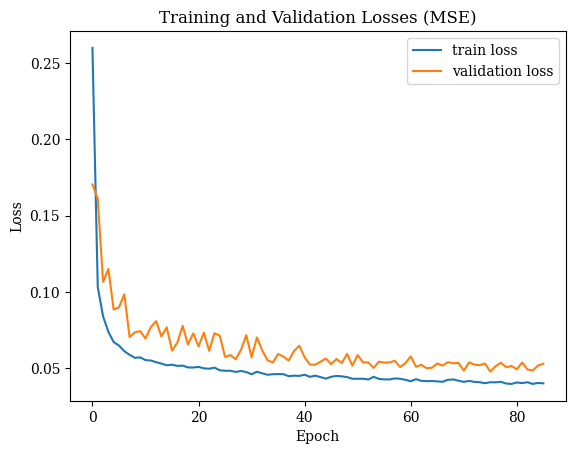

In [13]:
import matplotlib
matplotlib.rcParams['text.usetex'] = False
import matplotlib.pyplot as plt

# Loss
indices = loss_values[0] != 0
train_losses = loss_values[0][indices]
val_losses = loss_values[1][indices]

plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="validation loss")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Losses (MSE)")
plt.show()

### Testing

In [14]:
# Testing
test_loss = 0.

# Configure the model for testing
model.eval()

with torch.no_grad():
    # Loop over the testing batches
    for images, traversal_costs, _ in test_loader:
        
        images = images.to(device)
        traversal_costs = traversal_costs.to(device)
        
        # Perform forward pass
        predicted_traversal_costs = model(images)
        
        # Compute loss
        loss = criterion(predicted_traversal_costs[:, 0], traversal_costs)
        
        # Accumulate batch loss to average of the entire testing set
        test_loss += loss.item()
        
# Compute the loss and accuracy
test_loss /= len(test_loader)

print("Test loss: ", test_loss)

Test loss:  0.04685214931313757


In [15]:
images, traversal_costs, _ = next(iter(test_loader))

images = images.to(device)
traversal_costs = traversal_costs.to(device)

predicted_traversal_scores = model(images)
# predicted_traversal_scores = nn.Softmax(dim=1)(model(images))

print("Output:\n", predicted_traversal_costs)
print("Ground truth:\n", traversal_costs)

# print(predicted_traversal_scores-traversal_scores)

# predicted_traversal_scores = predicted_traversal_scores.to("cpu").detach().numpy()
# plt.hist(predicted_traversal_scores)

Output:
 tensor([[1.9164],
        [1.1540],
        [1.7049],
        [1.7565],
        [1.8200],
        [1.7674],
        [1.8607],
        [1.7817],
        [1.7092],
        [1.7018],
        [1.5376],
        [1.2646],
        [1.7354],
        [1.8251],
        [1.4132],
        [1.8508],
        [1.0743],
        [1.7494],
        [1.7478],
        [1.2801],
        [1.6915],
        [1.4558],
        [1.3510],
        [1.6658],
        [1.6654],
        [1.4208]])
Ground truth:
 tensor([1.4431, 1.8142, 1.4213, 1.8988, 1.6864, 1.0896, 1.3164, 1.1830, 1.9168,
        1.0740, 1.7578, 1.9497, 1.1054, 1.4927, 2.1730, 1.6349, 1.9143, 1.6020,
        1.8331, 2.0072, 1.7344, 1.1041, 1.8847, 1.4045, 0.9980, 2.2835, 1.8514,
        1.1247, 2.0487, 1.2955, 1.9082, 1.9524], dtype=torch.float64)


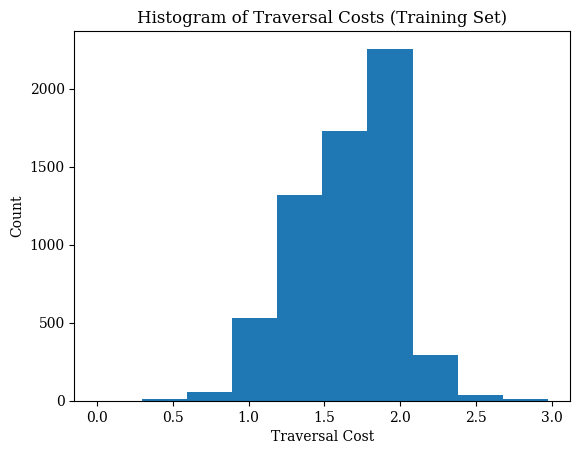

In [16]:
traversal_costs_train = []

for _, score, _ in train_set:
    traversal_costs_train.append(score)
    
plt.hist(traversal_costs_train, bins=10)
plt.xlabel("Traversal Cost")
plt.ylabel("Count")
plt.title("Histogram of Traversal Costs (Training Set)")
plt.show()


### Save model parameters

In [17]:
# Save the model parameters
torch.save(model.state_dict(), "mobilenet.params")